In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
from PIL import Image

folder_path = '/kaggle/input/tree-binary-segmentation/images/images'
def csv(folder_path):
    image_files = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
    ])

    image_data = []

    for file_name in image_files:
        full_path = os.path.join(folder_path, file_name)
    
        try:
            with Image.open(full_path) as img:
                img.verify()  

                image_data.append({'file':file_name,'full_path_mask': full_path})
        except Exception as e:
            print(f"corrupted: {file_name} -> {e}")

    df = pd.DataFrame(image_data)
    csv_path = 'image_paths.csv'

    return df

def csv_(folder_path):
    image_files = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
    ])

    image_data = []

    for file_name in image_files:
        full_path = os.path.join(folder_path, file_name)
    
        try:
            with Image.open(full_path) as img:
                img.verify()  

                image_data.append({'file':file_name,'full_path': full_path})
        except Exception as e:
            print(f"corrupted: {file_name} -> {e}")

    df = pd.DataFrame(image_data)
    csv_path = 'image_paths.csv'

    return df



In [3]:
train_path = csv_(folder_path = '/kaggle/input/tree-binary-segmentation/images/images')


In [4]:
train_masks = csv(folder_path = '/kaggle/input/tree-binary-segmentation/masks/masks')

In [5]:
train_masks

,file,full_path_mask
0,0.png,/kaggle/input/tree-binary-segmentation/masks/m...
1,1.png,/kaggle/input/tree-binary-segmentation/masks/m...
2,10.png,/kaggle/input/tree-binary-segmentation/masks/m...
3,100.png,/kaggle/input/tree-binary-segmentation/masks/m...
4,1000.png,/kaggle/input/tree-binary-segmentation/masks/m...
...,...,...
2713,995.png,/kaggle/input/tree-binary-segmentation/masks/m...
2714,996.png,/kaggle/input/tree-binary-segmentation/masks/m...
2715,997.png,/kaggle/input/tree-binary-segmentation/masks/m...
2716,998.png,/kaggle/input/tree-binary-segmentation/masks/m...


In [6]:
data = pd.concat([train_path,train_masks], axis= 1)

In [7]:
data.drop('file', axis=1, inplace = True)

In [8]:
data.shape

(2718, 2)

In [9]:
data.head()

,full_path,full_path_mask
0,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
1,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
2,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
3,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
4,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = data.drop('full_path_mask', axis=1)
y = data.drop('full_path', axis = 1)



In [12]:
y.head()

,full_path_mask
0,/kaggle/input/tree-binary-segmentation/masks/m...
1,/kaggle/input/tree-binary-segmentation/masks/m...
2,/kaggle/input/tree-binary-segmentation/masks/m...
3,/kaggle/input/tree-binary-segmentation/masks/m...
4,/kaggle/input/tree-binary-segmentation/masks/m...


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.1,random_state = 42, shuffle = True)

In [14]:
from io import BytesIO

In [15]:
X_train['image'] =X_train['full_path'].apply(lambda x: open(x, 'rb').read())
X_train.drop(['full_path'], axis= 1, inplace = True)


In [16]:
y_train.head()

,full_path_mask
1218,/kaggle/input/tree-binary-segmentation/masks/m...
1158,/kaggle/input/tree-binary-segmentation/masks/m...
1415,/kaggle/input/tree-binary-segmentation/masks/m...
2461,/kaggle/input/tree-binary-segmentation/masks/m...
1527,/kaggle/input/tree-binary-segmentation/masks/m...


In [17]:
y_train['image'] =y_train['full_path_mask'].apply(lambda x: open(x, 'rb').read())
y_train.drop(['full_path_mask'], axis= 1, inplace = True)
X_val['image'] =X_val['full_path'].apply(lambda x: open(x, 'rb').read())
X_val.drop(['full_path'], axis= 1, inplace = True)
y_val['image'] =y_val['full_path_mask'].apply(lambda x: open(x, 'rb').read())
y_val.drop(['full_path_mask'], axis= 1, inplace = True)


In [18]:
X_train['image'] = X_train['image'].apply(lambda x: Image.open(BytesIO(x)).convert('RGB'))
y_train['image'] = y_train['image'].apply(lambda x: Image.open(BytesIO(x)).convert('L'))
X_val['image'] = X_val['image'].apply(lambda x: Image.open(BytesIO(x)).convert('RGB'))
y_val['image'] = y_val['image'].apply(lambda x: Image.open(BytesIO(x)).convert('L'))

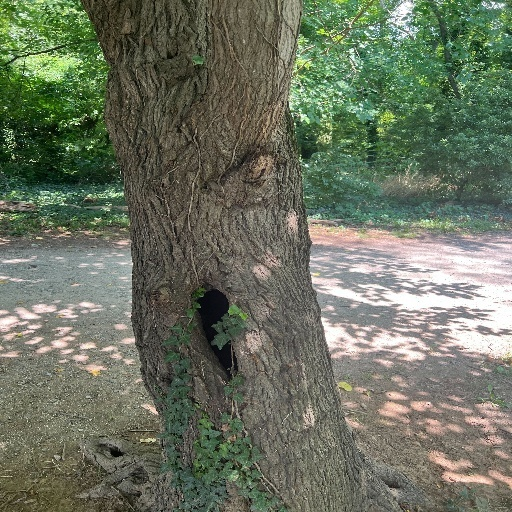

In [19]:
X_train.iloc[0]['image']


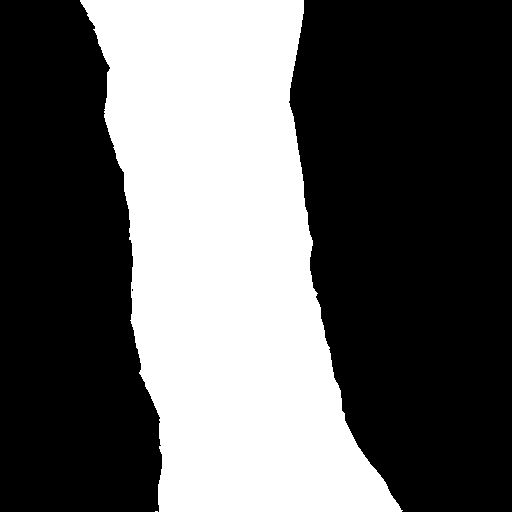

In [20]:
y_train.iloc[0]['image']

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50

In [22]:
transformer =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]) 

In [23]:

label_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [24]:
class dataset(Dataset):
    def __init__(self,dataframe, transformer = None , label_trans = None):
        super().__init__()
        self.dataframe = dataframe
        self.transformer = transformer
        self.label_trans = label_trans
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self,idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']

        if self.transformer:
            image = self.transformer(image)
        if self.label_trans:    
            label = self.label_trans(label)
        return image, label



In [25]:
y_train['label'] = y_train['image']
y_train.drop('image', axis=1, inplace =True)

y_val['labal'] = y_val['image']
y_val.drop('image', axis = 1, inplace = True)

In [26]:
y_val['label'] = y_val['labal']

In [27]:
y_val.drop('labal',axis=1,inplace=True)

In [28]:
train_data = pd.concat([X_train,y_train], axis = 1)
val_data = pd.concat([X_val,y_val], axis = 1)

In [29]:
val_data.head()

,image,label
2072,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
443,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
1397,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
2567,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
1017,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...


In [30]:
train_dataset = dataset(train_data, transformer = transformer, label_trans=label_transform)
val_dataset = dataset(val_data, transformer = transformer, label_trans=label_transform)

In [31]:
image,_ = val_dataset[0]



In [32]:
type(_)

torch.Tensor

In [33]:
train_loader = DataLoader(train_dataset, batch_size = 3)
val_loader = DataLoader(val_dataset, batch_size = 3)

In [34]:
import torch
import torch.nn as nn


In [35]:
not_my_model = resnet50()

In [36]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv, with crucial padding fix for non-power-of-2 sizes."""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match the size of x2 (the skip connection)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class Model(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(Model, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [38]:
bohrium_model = Model()

In [39]:
optimizer = torch.optim.Adam(bohrium_model.parameters(), lr= 1e-3, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
bohrium_model.to(device)

Model(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [40]:
from tqdm import tqdm
bohrium_model.train()
epochs = 50
losses = 0
for epoch in range(epochs):
    pbar = tqdm(train_loader, desc=f'the epoch {epoch+1}/{epochs} then :')
    for image, label in pbar:
        image = image.to(device)
        label = label.to(device)
        
        if label.dim() == 4 and label.size(1) == 1:
            label = label.squeeze(1)
        label = label.long()
        output = bohrium_model(image)
        optimizer.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        losses += loss.item()*image.size(0)


      

the epoch 50/50 then :: 100%|██████████| 91/91 [00:09<00:00,  9.63it/s]


In [41]:
bohrium_model.eval()
correct = 0
total = 0
best_loss = float(0.7)  # You forgot to define this before
criterion = nn.CrossEntropyLoss()  # If not already defined

pbar = tqdm(val_loader, desc='In evaluation:', leave=True)
for image, label in pbar:
    image = image.to(device)
    label = label.to(device).squeeze().long()  # Ensure label is in long format for CE Loss

    with torch.no_grad():
        output = bohrium_model(image)  # Shape: [B, C, H, W]
        prediction = torch.argmax(output, dim=1)  # Shape: [B, H, W]

        loss = criterion(output, label)

        correct += (prediction == label).sum().item()
        total += label.numel()

    # Update progress bar with loss and current accuracy
    pbar.set_postfix({
        'loss': loss.item(),
        'accuracy': f"{correct / total:.4f}"
    })

print(f'\nFinal Accuracy: {correct / total:.4f}')


In evaluation:: 100%|██████████| 816/816 [00:33<00:00, 24.62it/s, loss=0.0598, accuracy=0.9417]


Final Accuracy: 0.9417


In [42]:
img, lab = val_dataset[0]
image, label = val_dataset[1]

In [43]:
type(label)

torch.Tensor

In [44]:
output = bohrium_model(img.unsqueeze(0).to(device))
pred = torch.argmax(output, dim = 1).cpu()
output = bohrium_model(image.unsqueeze(0).to(device))
prediction = torch.argmax(output, dim = 1).cpu()

In [45]:
pred.shape

torch.Size([1, 224, 224])

In [46]:
label.shape

torch.Size([1, 224, 224])

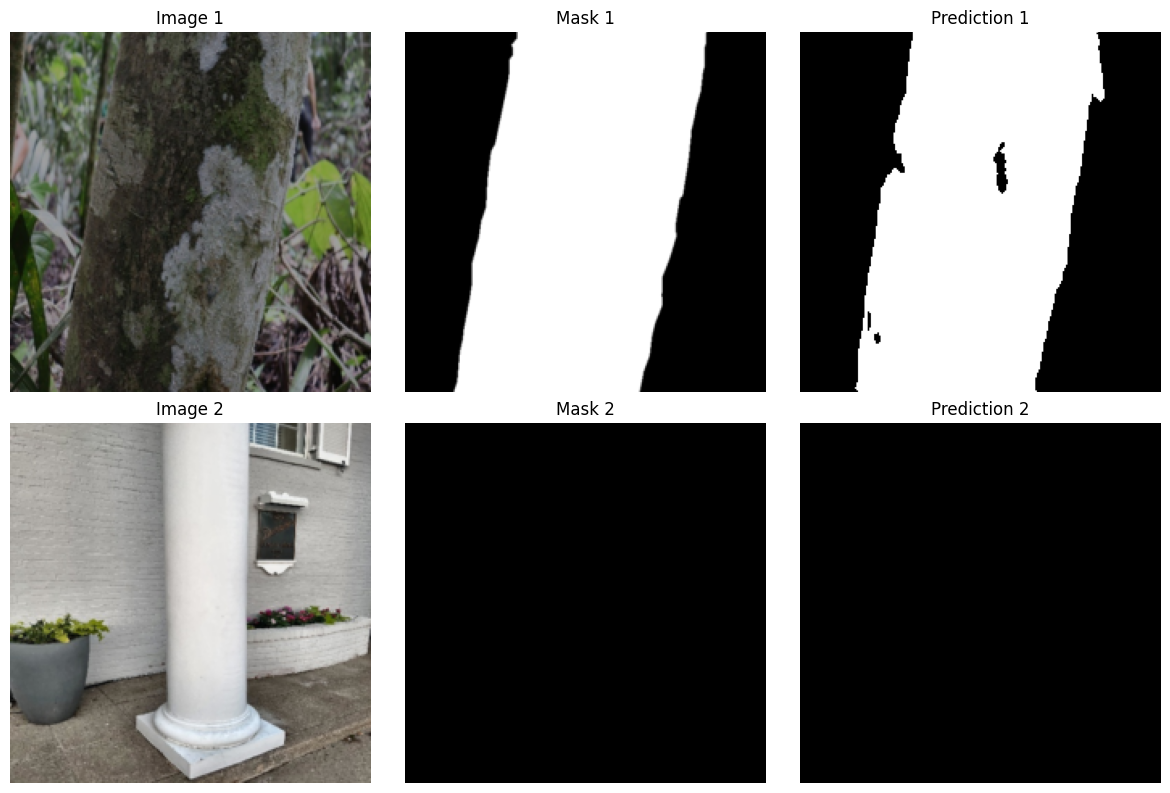

In [47]:
import matplotlib.pyplot as plt

# Create a 2-row, 3-column plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# First row (img, lab, pred)
axes[0, 0].imshow(img.view(-1, 224, 224).permute(1, 2, 0).cpu().numpy())
axes[0, 0].set_title("Image 1")
axes[0, 0].axis("off")

axes[0, 1].imshow(lab.squeeze().cpu().numpy(), cmap='gray')
axes[0, 1].set_title("Mask 1")
axes[0, 1].axis("off")

axes[0, 2].imshow(pred.squeeze().cpu().numpy(), cmap='gray')
axes[0, 2].set_title("Prediction 1")
axes[0, 2].axis("off")

# Second row (image, label, prediction)
axes[1, 0].imshow(image.view(-1, 224, 224).permute(1, 2, 0).cpu().numpy())
axes[1, 0].set_title("Image 2")
axes[1, 0].axis("off")

axes[1, 1].imshow(label.squeeze().cpu().numpy(), cmap='gray')
axes[1, 1].set_title("Mask 2")
axes[1, 1].axis("off")

axes[1, 2].imshow(prediction.squeeze().cpu().numpy(), cmap='gray')
axes[1, 2].set_title("Prediction 2")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()
